# Analysis

*New, continuing* -- part 2; progress report 2

**Table of Contents**

- [Introduction](#introduction)
- [Most common sound changes](#most-common-sound-changes)
- [How neighboring consonants affect vowel changes](#how-neighboring-consonants-affect-vowel-changes)
    - [Initial exploration and setup](#initial-exploration-and-setup)
    - [Analysis with t-tests](#analysis-with-t-tests)
        - [Place of consonant](#place-of-consonant)
        - [Voicing of consonant](#voicing-of-consonant)
        - [Manner of consonant](#manner-of-consonant)
    - [Am I even doing this right?](#am-i-even-doing-this-right)
        - [A short foray into linear regression](#a-short-foray-into-linear-regression-some-results)

## Introduction

I have a few questions about my data that I want to answer:

1. What are the most common sound changes?
    - I think this would be a good starting point for getting an idea of how the data can be analyzed.
2. How do neighboring consonants affect vowel changes?
    - This is probably quite difficult to really answer, but I have some ideas. In fact, I might just focus on answering this question; if I have extra time, I might also explore the next question I have:
3. What are some interesting connections that can be made by connecting strings of sound changes?
    - I just think this would be interesting, honestly.

In [1]:
import pandas as pd

In [2]:
from data_parsing_script import Branch, Rule

branches: list[Branch] = pd.read_pickle('./data/branches.pkl')
rules: list[Rule] = pd.read_pickle('./data/rules.pkl')

Analysis will be much easier if my data is in dataframe form, so I'll make that happen by using `from_records()` and `vars()` (which pulls each field value out of an object / class.)

In [3]:
rules_df = pd.DataFrame.from_records([vars(rule) for rule in rules])
rules_df.describe()

,id,branch_id,branch_index,original_text,environment,from_sound,intermediate_steps,to_sound
count,16496,16496,16496,16496,16496,16496,16496,16496
unique,8954,702,702,7042,2724,1965,141,1487
top,"Shetland-Norn-u,oː-a-aː-ɒ,œ,y-e-iː",Old-Norse,17.7.3.1,"{s,z}(ʔ) {ʃ,ʒ}(ʔ) {ɬ,ɮ}(ʔ) → s ʃ ɬ / _#",,e,[],∅
freq,40,371,371,48,7577,389,16205,1737


## Most common sound changes

Before finding what sound changes are "most common", I need to decide what makes two sound changes "the same." If the starting sound and ending sound are the same, but there are differing in-between sounds or differing environments, should they be considered to be the same? I think it'd be interesting to see if the results differ depending on which approach you take, so I'll be looking at both.

However, the `describe()` call above made me remember a potential confounding issue: there are a *lot* of sound changes that are essentially copied between different daughter languages in a single branch. If one sound change is shared between 15 daughter languages, should that really be considered "more common" than one that exists in 15 separate branches?

Because of this, I went back and modified my data parsing script to add the branch index. This will let me discount copies of the same sound change shared between sister branches on the same level.

As a starting point, let's see what the most common `from_sound`s and `to_sound`s are.

In [4]:
rules_df['from_sound'].value_counts()[:10]

e    389
k    384
t    362
a    339
s    326
p    310
u    288
i    252
j    250
o    244
Name: from_sound, dtype: int64

It makes sense that these are single IPA symbols, since they're the least complex possible sounds. I expect the 'to' sounds to be largely similar, with the addition of the null symbol.

In [5]:
rules_df['to_sound'].value_counts()[:10]

∅    1737
s     504
i     441
e     388
o     368
h     364
k     350
a     333
t     318
u     304
Name: to_sound, dtype: int64

I was correct! Although which sounds are present, and in which order, does change a bit. /s/ is, by far, the most common result of a sound change (other than the sound being removed.)

Now, let's just do a very basic version of the "most common sound change" idea -- what is the most common pairing of `from_sound` and `to_sound`?

In [6]:
rules_df[['from_sound', 'to_sound']].value_counts()[:10]

from_sound  to_sound
h           ∅           164
e           i           100
w           ∅            93
j           ∅            92
k           ∅            87
ʔ           ∅            87
V           ∅            74
o           u            73
n           ∅            72
ts          s            71
dtype: int64

/h/ being removed is most common, which makes a lot of sense to me -- this even happened in British English (e.g. "history".) /ts/ → /s/ is probably the most interesting inclusion on the list, but it's also not a very surprising change. Let's see what the most common are when excluding removed sounds:

In [7]:
rules_df[['from_sound', 'to_sound']][rules_df['to_sound'] != '∅'].value_counts()[:10]

from_sound  to_sound
e           i           100
o           u            73
ts          s            71
u           o            67
i           e            61
e           a            60
k           ɡ            60
a           e            58
s           ʃ            57
            h            56
dtype: int64

Nothing too surprising here. The empty row in the 'from' column is actually s → h; not sure why the notebook renders it that way, but it does. Now what if we include environment -- does that change things much?

In [8]:
rules_df[['from_sound', 'to_sound', 'environment']].value_counts()[:10]

from_sound  to_sound  environment
ts          s                        55
h           ∅                        44
ɡ           k                        34
TŠ          TS                       28
ʃ           s                        26
b           p                        25
iː          i                        25
tʃ          ts                       25
ʔ           ∅                        24
q           ∅                        24
dtype: int64

Things do change a bit. The weirdest thing here is definitely TŠ → TS, but looking at the data, this is due to the issue I mentioned earlier -- sounds copied between sister branches. The Athabaskan sound changes mostly involve *series* of consonants; "TŠ" represents palatals, while "TS" represents dental affricates & fricatives.

Let's see the same stats, but excluding sister branches. First, I'll add a column for "parent branch index", so we can find the number of unique parent branches that have a sound change, rather than a raw count of the sound change.

In [9]:
def get_parent_branch_index(branch_index: str):
  return '.'.join(branch_index.split('.')[:-1])

get_parent_branch_index('6.5.4.3.2')

'6.5.4.3'

In [10]:
import numpy as np
get_parent_branch_index_vec = np.vectorize(get_parent_branch_index)
rules_df['parent_index'] = get_parent_branch_index_vec(rules_df['branch_index'])
rules_df.groupby(['branch_index', 'parent_index']).size().head(10) # verify it worked

branch_index  parent_index
10.1          10               4
10.1.1        10.1            21
10.1.1.1      10.1.1           8
10.1.1.2      10.1.1          12
10.1.1.3      10.1.1          15
10.1.1.5      10.1.1           8
10.1.2        10.1            10
10.1.2.1      10.1.2          11
10.1.2.10     10.1.2          15
10.1.2.2      10.1.2          13
dtype: int64

Looks good! Let's get those stats again now.

In [11]:
rules_df[['from_sound', 'to_sound', 'parent_index']].drop_duplicates()[['from_sound', 'to_sound']].value_counts()[:10]

from_sound  to_sound
h           ∅           46
w           ∅           44
ʔ           ∅           40
k           ∅           37
j           ∅           34
e           i           34
a           e           32
i           e           30
u           o           29
o           u           29
dtype: int64

In [12]:
rules_df[['from_sound', 'to_sound', 'parent_index']][rules_df['to_sound'] != '∅'].drop_duplicates()[['from_sound', 'to_sound']].value_counts()[:10]

from_sound  to_sound
e           i           34
a           e           32
i           e           30
u           o           29
o           u           29
ts          s           27
s           ʃ           26
ɡ           k           24
k           ɡ           23
a           o           23
dtype: int64

These numbers are much lower than before, but the results are mostly similar, with a few sounds falling out of the top 10. Let's do the same with environment taken into account:

In [13]:
rules_df[['from_sound', 'to_sound', 'environment', 'parent_index']].drop_duplicates()[['from_sound', 'to_sound', 'environment']].value_counts()[:10]

from_sound  to_sound  environment
ts          s                        19
tʃ          ts                       15
ʔ           ∅                        15
h           ∅                        14
w           v                        14
ʃ           s                        14
ɡ           k                        12
dz          z                        12
b           p                        11
o           u                        11
dtype: int64

This definitely *feels* more representative now, and the commonness of all of these sound changes make sense to me.

Finally, let's take intermediate steps into account, with and without environment. (I have to do `.astype(str)` here because `drop_duplicates()` uses hashing, and list values (which is what `intermediate_steps` is) can't be hashed.)

In [14]:
rules_df[['from_sound', 'intermediate_steps', 'to_sound', 'parent_index']]\
  .astype(str).drop_duplicates()[['from_sound', 'intermediate_steps', 'to_sound']].value_counts()[:10]

from_sound  intermediate_steps  to_sound
h           []                  ∅           46
w           []                  ∅           43
ʔ           []                  ∅           40
k           []                  ∅           37
j           []                  ∅           34
e           []                  i           34
a           []                  e           32
i           []                  e           30
o           []                  u           29
u           []                  o           28
dtype: int64

No intermediate steps is, predictably, most common. What if we specify only rules *with* intermediate steps? Are there *any* that occur more than once?

In [15]:
counts = rules_df[rules_df['intermediate_steps'].apply(lambda x: len(x) > 0)][['from_sound', 'intermediate_steps', 'to_sound', 'parent_index']]\
  .astype(str).drop_duplicates()[['from_sound', 'intermediate_steps', 'to_sound']].value_counts()

counts[counts > 1]

from_sound  intermediate_steps  to_sound
ai          ['ɛi']              əi          2
ɛː          ['ɛi']              əi?         2
dtype: int64

It seems like there are two that occur more than once, but on further inspection, maybe not...

In [16]:
rules_df[(rules_df['from_sound'] == 'ai') & (rules_df['to_sound'] == 'əi')]

,id,branch_id,branch_index,original_text,environment,from_sound,intermediate_steps,to_sound,parent_index
6634,Scots-—-ai,Scots,17.7.2.1.9,— ai → ɛi → əi / when stem-final,when stem-final,ai,[ɛi],əi,17.7.2.1
16259,Scots-Vowel-Shifts-ai,Scots-Vowel-Shifts,46.5,ai → ɛi → əi / when stem-final,when stem-final,ai,[ɛi],əi,46


In [17]:
rules_df[rules_df['to_sound'] == 'əi?']

,id,branch_id,branch_index,original_text,environment,from_sound,intermediate_steps,to_sound,parent_index
6658,Scots-—-ɛː,Scots,17.7.2.1.9,— ɛː → ɛi (→ əi?) / in some northern varieties,in some northern varieties,ɛː,[ɛi],əi?,17.7.2.1
16283,Scots-Vowel-Shifts-ɛː,Scots-Vowel-Shifts,46.5,ɛː → ɛi (→ əi?) / in some northern varieties,in some northern varieties,ɛː,[ɛi],əi?,46


...both of these are just duplicated between the Scots section and the Vowel Shifts section. Oh well.

## How neighboring consonants affect vowel changes

### Initial exploration and setup

Let's start by loading in the vowel change data and reminding ourselves what that data looks like.

In [18]:
from ipapy.ipachar import IPAConsonant, IPAVowel, IPAChar
from ipapy.ipastring import IPAString

vowel_changes_df: pd.DataFrame = pd.read_pickle('./data/vowel_changes.pkl')

In [19]:
vowel_changes_df.describe()

,before,from_vowel,to_vowel,after,original_text,parent_index,before_voicing,before_place,before_manner,before_modifiers,...,from_length,to_height,to_backness,to_roundness,to_modifiers,to_length,after_voicing,after_place,after_manner,after_modifiers
count,1807,6172,4967,3661,6172,6172,1807,1807,1807,1807,...,6172,4967,4967,4967,4967,4967,3661,3661,3661,3661
unique,1688,3806,3162,3489,1743,132,4,16,15,8,...,3,8,6,3,6,3,4,15,15,10
top,[j],[e],[i],[θ],a(ː) ae → o(ː) ɒø / #(C)(C)(C)_(C)(C)(C)u,17.7.3,anyv,anyp,anym,[],...,,close-mid,front,unrounded,[],,anyv,anyp,anym,[]
freq,8,120,120,16,224,611,846,769,760,1737,...,5197,1821,2599,2719,4752,4064,1785,1678,1540,3509


In [20]:
vowel_changes_df[-10:]

,before,from_vowel,to_vowel,after,original_text,parent_index,before_voicing,before_place,before_manner,before_modifiers,...,from_length,to_height,to_backness,to_roundness,to_modifiers,to_length,after_voicing,after_place,after_manner,after_modifiers
6162,None,[y],[u],None,"y → u (some mainland Greek dialects, and Tsako...",47,None,None,None,None,...,,close,back,rounded,[],,None,None,None,None
6163,None,[y],[u],None,"y → u (some mainland Greek dialects, and Tsako...",47,None,None,None,None,...,,close,back,rounded,[],,None,None,None,None
6164,None,[i],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,,None,None,None,None,None,None,None,None,None
6165,None,[i],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,,None,None,None,None,None,None,None,None,None
6166,None,[i],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,,None,None,None,None,None,None,None,None,None
6167,None,[i],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,,None,None,None,None,None,None,None,None,None
6168,None,[u],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,,None,None,None,None,None,None,None,None,None
6169,None,[u],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,,None,None,None,None,None,None,None,None,None
6170,None,[u],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,,None,None,None,None,None,None,None,None,None
6171,None,[u],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,,None,None,None,None,None,None,None,None,None


Now, let's start classifying each sound change by *how* it changes the vowel -- its height, backness, roundedness, length, modifiers, and deletion. I'll define a bunch of functions that assign values to these changes, and create columns in the dataframe using those function.

In [21]:
def height_change(row):
  heights = {'open': 0, 'near-open': 1, 'open-mid': 2, 'mid': 3, 'close-mid': 4, 'near-close': 5, 'close': 6}
  if row['to_height'] == None:
    return None
  if row['from_height'] == 'anyh' or row['to_height'] == 'anyh':
    return None
  return heights[row['to_height']] - heights[row['from_height']]

def backness_change(row):
  backnesses = {'front': 0, 'near-front': 1, 'central': 2, 'near-back': 3, 'back': 4}
  if row['to_backness'] == None:
    return None
  if row['from_backness'] == 'anyb' or row['to_backness'] == 'anyb':
    return None
  return backnesses[row['to_backness']] - backnesses[row['from_backness']]

def roundness_change(row):
  roundnesses = {'unrounded': 0, 'rounded': 1}
  if row['to_roundness'] == None:
    return None
  if row['from_roundness'] == 'anyr' or row['to_roundness'] == 'anyr':
    return None
  return roundnesses[row['to_roundness']] - roundnesses[row['from_roundness']]

def length_change(row):
  # short is just an empty string
  lengths = {'extra-short': 0, '': 1, 'long': 2}
  if row['to_length'] == None:
    return None
  if row['from_length'] == 'anyl' or row['to_length'] == 'anyl':
    return None
  return lengths[row['to_length']] - lengths[row['from_length']]

def modifier_change(row):
  if row['to_modifiers'] == None:
    row['added_modifiers'] = None
    row['removed_modifiers'] = None
    return row
  from_mod, to_mod = set(row['from_modifiers']), set(row['to_modifiers'])
  row['added_modifiers'] = list(from_mod - to_mod)
  row['removed_modifiers'] = list(to_mod - from_mod)
  return row

def deletion_change(row):
  if row['to_vowel'] == None:
    return True
  return False

In [22]:
vowel_changes_df['height_change'] = vowel_changes_df.apply(height_change, axis=1)
vowel_changes_df['backness_change'] = vowel_changes_df.apply(backness_change, axis=1)
vowel_changes_df['roundness_change'] = vowel_changes_df.apply(roundness_change, axis=1)
vowel_changes_df['length_change'] = vowel_changes_df.apply(length_change, axis=1)
vowel_changes_df: pd.DataFrame = vowel_changes_df.apply(modifier_change, axis=1)
vowel_changes_df['deletion'] = vowel_changes_df.apply(deletion_change, axis=1)

In [23]:
vowel_changes_df

,before,from_vowel,to_vowel,after,original_text,parent_index,before_voicing,before_place,before_manner,before_modifiers,...,after_place,after_manner,after_modifiers,height_change,backness_change,roundness_change,length_change,added_modifiers,removed_modifiers,deletion
0,None,"[a, ː]","[e, ː]",[ʕ],"a(ː) → e(ː) / _{ʕ,q}$",6,None,None,None,None,...,pharyngeal,non-sibilant-fricative,[],4.0,0.0,0.0,0.0,[],[],False
1,None,"[a, ː]","[e, ː]",[q],"a(ː) → e(ː) / _{ʕ,q}$",6,None,None,None,None,...,uvular,plosive,[],4.0,0.0,0.0,0.0,[],[],False
2,None,[a],"[e, ː]",[ʕ],"a(ː) → e(ː) / _{ʕ,q}$",6,None,None,None,None,...,pharyngeal,non-sibilant-fricative,[],4.0,0.0,0.0,1.0,[],[],False
3,None,[a],"[e, ː]",[q],"a(ː) → e(ː) / _{ʕ,q}$",6,None,None,None,None,...,uvular,plosive,[],4.0,0.0,0.0,1.0,[],[],False
4,None,"[a, ː]",[e],[ʕ],"a(ː) → e(ː) / _{ʕ,q}$",6,None,None,None,None,...,pharyngeal,non-sibilant-fricative,[],4.0,0.0,0.0,-1.0,[],[],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,None,[i],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,None,None,None,NaN,NaN,NaN,NaN,None,None,True
6168,None,[u],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,None,None,None,NaN,NaN,NaN,NaN,None,None,True
6169,None,[u],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,None,None,None,NaN,NaN,NaN,NaN,None,None,True
6170,None,[u],None,None,"i u → s̩ f̩ (Ōgami) (<a href=""http://amritas.c...",47,None,None,None,None,...,None,None,None,NaN,NaN,NaN,NaN,None,None,True


Now let's look at some heatmaps! How does the "place" of the preceding consonant affect the change in height of a vowel?

<Axes: xlabel='height_change', ylabel='after_place'>

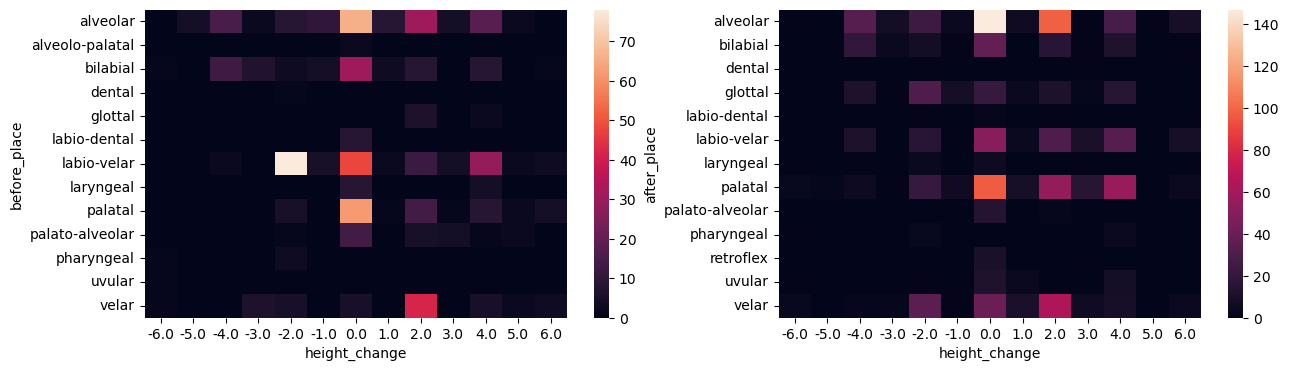

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15,4))

sns.heatmap(pd.crosstab(vowel_changes_df['before_place'], vowel_changes_df['height_change'], dropna=True).drop(['', 'anyp']), ax=ax[0])
sns.heatmap(pd.crosstab(vowel_changes_df['after_place'], vowel_changes_df['height_change'], dropna=True).drop(['', 'anyp']), ax=ax[1])

It's not super easy to tell what's going on here, although it's clear that height changes seem to be skewed for some types of consonants. Let's try getting the means of each grouping and seeing whether that makes any tendencies clearer.

In [25]:
vowel_changes_df['height_change'].mean() # baseline

0.40241065764432227

In [26]:
vowel_changes_df[['before_place', 'height_change']]\
  .groupby(['before_place'], dropna=True)\
  .agg(['mean', 'count'])\
  .drop(['', 'anyp'])\
  .reset_index()\
  .sort_values(('height_change', 'mean'), ascending=False)

before_place height_change      
                             mean count
4           glottal      2.500000     8
13            velar      1.420290    69
7         laryngeal      1.333333    12
9   palato-alveolar      1.259259    27
8           palatal      0.907216    97
0          alveolar      0.309524   168
6       labio-velar      0.070270   185
1   alveolo-palatal      0.000000     2
5      labio-dental      0.000000     8
2          bilabial     -0.405063    79
3            dental     -2.000000     1
10       pharyngeal     -3.000000     4
12           uvular     -6.000000     1
11        retroflex           NaN     0

In [27]:
vowel_changes_df[['after_place', 'height_change']]\
  .groupby(['after_place'], dropna=True)\
  .agg(['mean', 'count'])\
  .drop(['', 'anyp'])\
  .reset_index()\
  .sort_values(('height_change', 'mean'), ascending=False)

after_place height_change      
                             mean count
5       labio-velar      1.237805   164
7           palatal      1.139194   273
11           uvular      1.076923    26
12            velar      0.634286   175
2            dental      0.500000     2
9        pharyngeal      0.500000     8
0          alveolar      0.449721   358
10        retroflex      0.272727    11
8   palato-alveolar      0.250000    16
4      labio-dental      0.000000     4
1          bilabial     -0.142857    98
3           glottal     -0.223301   103
6         laryngeal     -1.250000    12

There are definitely some tendencies here. Interestingly, most vowel changes seem to be increasing in height, regardless of the consonant before or after. However, the differing sample sizes make this a bit more uncertain.

### Analysis with t-tests
Let's try adding in a t-test to see whether the tendencies are significant when compared to the overall tendencies. (I'll also put this all in a function to make it easier to use later on.)

In [28]:
# RuntimeWarnings fire whenever a certain case has 0 values -- these don't affect anything, so just ignore
import warnings
warnings.filterwarnings('ignore')

In [29]:
from scipy.stats import ttest_ind

def t_test_vs_complement(group: pd.Series, vowel_att: str):
  complement = vowel_changes_df['height_change'].drop(group.index)
  (t_stat, p_val) = ttest_ind(group, complement, nan_policy='omit')
  if np.ma.is_masked(t_stat) or np.ma.is_masked(p_val): # this happens if <2 non-na vals
    return (None, None)
  return (t_stat, p_val)

def change_stats(df: pd.DataFrame, consonant_att: str, vowel_att: str):
  change_stats_df = df[[consonant_att, vowel_att]]\
    .groupby([consonant_att], dropna=True)\
    .agg(['mean', 'count', lambda x: t_test_vs_complement(x, vowel_att)])\
    .drop(['', 'anyp'])\
    .reset_index()

  change_stats_df[[(vowel_att, 't_statistic'), (vowel_att, 'p_value')]] = pd.DataFrame(change_stats_df[(vowel_att, '<lambda_0>')].tolist(), index=change_stats_df.index)
  change_stats_df = change_stats_df.drop((vowel_att, '<lambda_0>'), axis=1)
  return change_stats_df.sort_values((vowel_att, 't_statistic'), ascending=False)

before_place_vs_height = change_stats(vowel_changes_df, 'before_place', 'height_change')
before_place_vs_height

before_place height_change                            
                             mean count t_statistic   p_value
13            velar      1.420290    69    3.497374  0.000474
4           glottal      2.500000     8    2.436543  0.014865
8           palatal      0.907216    97    2.060982  0.039359
9   palato-alveolar      1.259259    27    1.831689  0.067061
7         laryngeal      1.333333    12    1.324357  0.185449
1   alveolo-palatal      0.000000     2   -0.233425  0.815442
5      labio-dental      0.000000     8   -0.467155  0.640411
0          alveolar      0.309524   168   -0.502740  0.615170
6       labio-velar      0.070270   185   -1.890626  0.058735
10       pharyngeal     -3.000000     4   -2.794005  0.005227
2          bilabial     -0.405063    79   -2.970802  0.002985
3            dental     -2.000000     1         NaN       NaN
11        retroflex           NaN     0         NaN       NaN
12           uvular     -6.000000     1         NaN       NaN

In [30]:
after_place_vs_height = change_stats(vowel_changes_df, 'before_place', 'height_change')
after_place_vs_height

before_place height_change                            
                             mean count t_statistic   p_value
13            velar      1.420290    69    3.497374  0.000474
4           glottal      2.500000     8    2.436543  0.014865
8           palatal      0.907216    97    2.060982  0.039359
9   palato-alveolar      1.259259    27    1.831689  0.067061
7         laryngeal      1.333333    12    1.324357  0.185449
1   alveolo-palatal      0.000000     2   -0.233425  0.815442
5      labio-dental      0.000000     8   -0.467155  0.640411
0          alveolar      0.309524   168   -0.502740  0.615170
6       labio-velar      0.070270   185   -1.890626  0.058735
10       pharyngeal     -3.000000     4   -2.794005  0.005227
2          bilabial     -0.405063    79   -2.970802  0.002985
3            dental     -2.000000     1         NaN       NaN
11        retroflex           NaN     0         NaN       NaN
12           uvular     -6.000000     1         NaN       NaN

Now it's much more clear that palatal consonants have a clear tendency to raise the height of vowels.

There are too many combinations to do this for every single one. However, we can try to turn these findings into a heatmap, where each row is a "place", while each column is a numeric change -- height, backness, roundness, and length.

First, I'll set up the functions to build the visualizations:

In [31]:
from matplotlib.patches import Rectangle
from typing import cast

def t_test_cols_vs_complement(group: pd.DataFrame, cols: list[str], use_p_val: bool):
  out_cols = {}
  for col in cols:
    (t_stat, p_val) = t_test_vs_complement(group[col], col)
    out_cols[col] = p_val if use_p_val else t_stat
  return pd.Series(out_cols)

def t_heatmap(t_stats_df: pd.DataFrame, p_vals_df: pd.DataFrame, axes: plt.Axes):
  sns.heatmap(t_stats_df, center=0, cmap='vlag', square=True, ax=axes)
  for col_i, col in enumerate(p_vals_df.columns.values.tolist()):
    for row_i, row in enumerate(p_vals_df.index.values.tolist()):
      if p_vals_df[col][row] < 0.05:
        axes.add_patch(Rectangle((col_i, row_i), 1, 1, fill=False, edgecolor='black', lw=1, clip_on=False))

numeric_vowel_cols = ['height_change', 'backness_change', 'roundness_change', 'length_change']

def plot_change_stats(consonant_att: str, axes: plt.Axes, groups: list[str]):
  change_t_stats = vowel_changes_df[[consonant_att] + numeric_vowel_cols]\
    .groupby([consonant_att])\
    .apply(lambda x: t_test_cols_vs_complement(x, numeric_vowel_cols, False))\
    .reindex(groups)

  change_p_vals = vowel_changes_df[[consonant_att] + numeric_vowel_cols]\
    .groupby([consonant_att])\
    .apply(lambda x: t_test_cols_vs_complement(x, numeric_vowel_cols, True))\
    .reindex(groups)

  t_heatmap(change_t_stats, change_p_vals, axes)


#### Place of consonant

*boxes represent statistically significant differences from the overall mean*

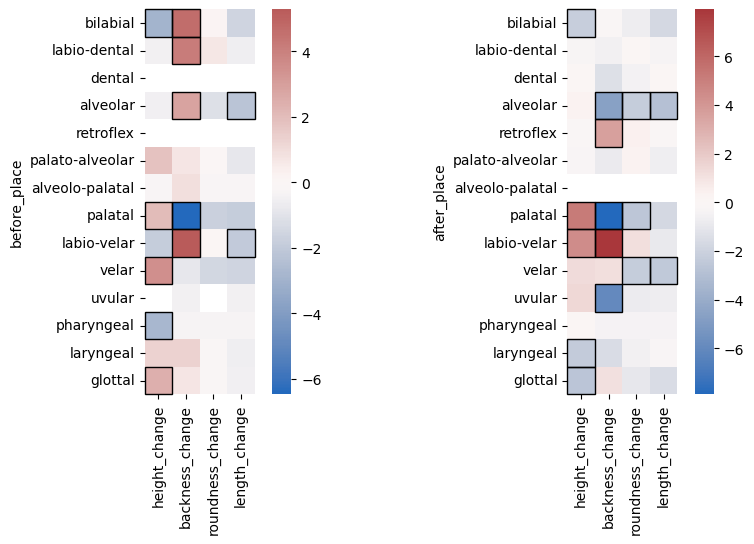

In [32]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10,5))

places = ['bilabial', 'labio-dental', 'dental', 'alveolar', 'retroflex', 'palato-alveolar', 'alveolo-palatal', 'palatal', 'labio-velar', 'velar', 'uvular', 'pharyngeal', 'laryngeal', 'glottal']
plot_change_stats('before_place', ax[0], cast(list[str], places))
plot_change_stats('after_place', ax[1], cast(list[str], places))

There are some very clear takeaways here.

##### Height

First, palatal consonants clearly tend to raise the height of vowels nearby, regardless of whether they come before or after the vowel; this is not surprising. I'm surprised that velar consonants show a stronger raising effect when preceding vowels than palatal consonants, though. Additionally, preceding glottal and laryngeal consonants having a weak raising effect when before a vowel, but a weak lowering affect when after a vowel, is definitely surprising; I don't have a good explanation for that. Labio-velar consonants having the opposite effect of glottal/laryngeal consonants is also odd to me.

##### Backness

The most striking finding here is that labio-velar consonants (essentially just /w/) have a very strong backing effect; this makes sense to me, as /w/ is very similar to /u/ in how it's pronounced. Palatal consonants have the opposite effect, which is also unsurprising to me. Preceding bilabial or labiodental consonants having a backing effect also makes some sense to me, but that might just because of their similarity with /w/ -- I don't have an explanation more specific than that. However, I can't explain why uvular consonants seem to have a strong fronting effect when following vowels, why retroflex consonants have a backing effect, or why alveolar consonants have a backing effect when preceding, but a raising effect when following.

##### Roundness

I'm really surprised that bilabial and labio-velar consonants seem to have no association with vowels becoming more rounded. The only significant association is that following palatal, velar, and alveolar consonants seem to have an un-rounding effect.

##### Length

Many types of consonants seem to be associated with shortening vowel length (most too weak to be statistically significant), but none are associated with lengthening. Consonants may have an inherent shortening effect regardless of their place of articulation.

##### Modifiers

To-do.

#### Voicing of consonant

*boxes represent statistically significant differences from the overall mean*

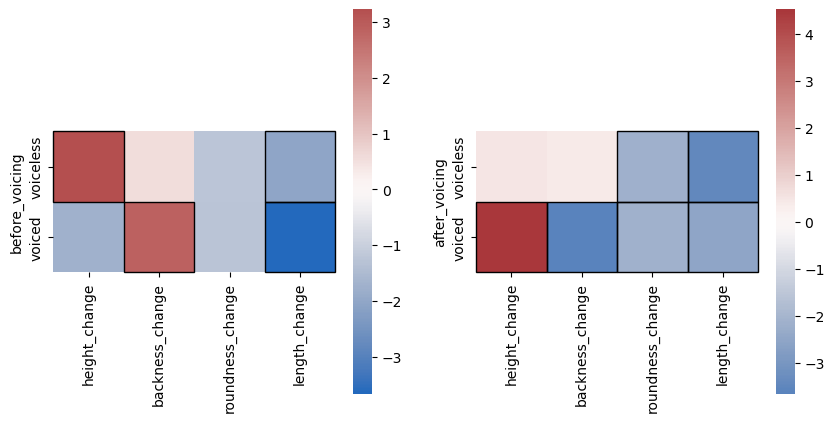

In [33]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10,5))

voicings = ['voiceless', 'voiced']
plot_change_stats('before_voicing', ax[0], cast(list[str], voicings))
plot_change_stats('after_voicing', ax[1], cast(list[str], voicings))

##### Height, backness, rounding, and length

I have no explanation for any of these effects, honestly. This feels totally random. My guess is that correlations between different features of consonants are confounding the results -- for example, voiced, following consonants may tend to be palatal consonants more often. A future avenue for improving this analysis would be to try to control for this.

##### Modifiers

To-do.

#### Manner of consonant

*boxes represent statistically significant differences from the overall mean*

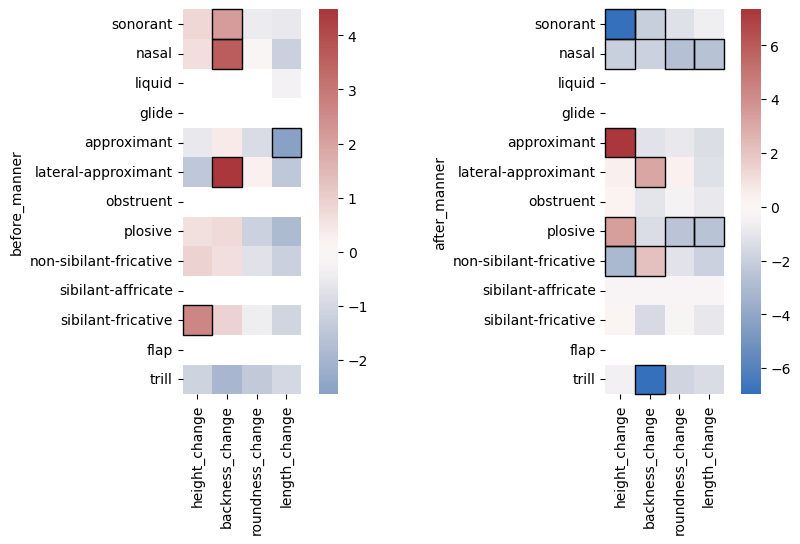

In [34]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10,5))

manners = ['sonorant', 'nasal', 'liquid', 'glide', 'approximant', 'lateral-approximant', 'obstruent', 'plosive', 'non-sibilant-fricative', 'sibilant-affricate', 'sibilant-fricative', 'flap', 'trill']
plot_change_stats('before_manner', ax[0], cast(list[str], manners))
plot_change_stats('after_manner', ax[1], cast(list[str], manners))

##### Height, backness, rounding, and length

I again have no real explanation for any of these effects; the same confounding factors may be at play here.

##### Modifiers

To-do.

### Am I even doing this right?

After doing all of this and realizing I needed to deal with these confounding factors, I looked into what I could do to try and untangle these effects and figure out their actual causes. The approach I decided on was to do a linear regression and see what coefficients were determined to be statistically significant, and do a similar visualization using that data. I hoped this would untangle some of the issues I was having.

Unfortunately, it really did not. What I found was that which dummy columns I included significantly influenced what was considered to be significant. Excluding columns with just 1 observation, for example, completely changed which effects were statistically significant. In addition, some of the results I had that I thought made sense in the previous section -- for example, palatal consonants having a strong fronting effect -- were completely gone. I have no idea why.

For posterity, I've included an excerpt of those results below, but my conclusion from this whole endeavor is that I just do not have the statistics know-how to really figure out how to determine which values of which features cause which effects.

#### A short foray into linear regression: some results

In [1]:
# Remove the most highly correlated features first
vowel_changes_dummies_df = pd.get_dummies(vowel_changes_df, columns=['before_place', 'before_manner', 'before_voicing', 'after_place', 'after_manner', 'after_voicing'], drop_first=True)\
  .drop(['before_modifiers', 'after_modifiers'], axis=1)

# Remove dummies with only 1 observation
min_drop = [column for column in vowel_changes_dummies_df.columns if (column.startswith('before_') or column.startswith('after_')) and sum(vowel_changes_dummies_df[column]) < 2]

print(min_drop)

# Drop those columns
vowel_changes_dummies_df.drop(min_drop, axis=1, inplace=True)

# Get feature correlations
corr_matrix = vowel_changes_dummies_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
# Also drop modifiers, ignoring those for now
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(to_drop)

# Drop those columns
vowel_changes_dummies_df.drop(to_drop, axis=1, inplace=True)

NameError: name 'pd' is not defined

In [ ]:
import statsmodels.api as sm

# Fit linear models and grab the relevant columns from each coefficient summary table
def get_fit_ts(before_or_after: str):
  dummy_cols = vowel_changes_dummies_df[[col for col in vowel_changes_dummies_df if col.startswith(f'{before_or_after}_')]]
  height_fit = sm.OLS(vowel_changes_dummies_df['height_change'], dummy_cols, missing='drop').fit().summary2().tables[1][['t', 'P>|t|']].set_axis(['height_change', 'height_change_p'], axis=1)
  backness_fit = sm.OLS(vowel_changes_dummies_df['backness_change'], dummy_cols, missing='drop').fit().summary2().tables[1][['t', 'P>|t|']].set_axis(['backness_change', 'backness_change_p'], axis=1)
  roundness_fit = sm.OLS(vowel_changes_dummies_df['roundness_change'], dummy_cols, missing='drop').fit().summary2().tables[1][['t', 'P>|t|']].set_axis(['roundness_change', 'roundness_change_p'], axis=1)
  length_fit = sm.OLS(vowel_changes_dummies_df['length_change'], dummy_cols, missing='drop').fit().summary2().tables[1][['t', 'P>|t|']].set_axis(['length_change', 'length_change_p'], axis=1)

  return height_fit.join(backness_fit).join(roundness_fit).join(length_fit)

before_ts = get_fit_ts('before')
after_ts = get_fit_ts('after')

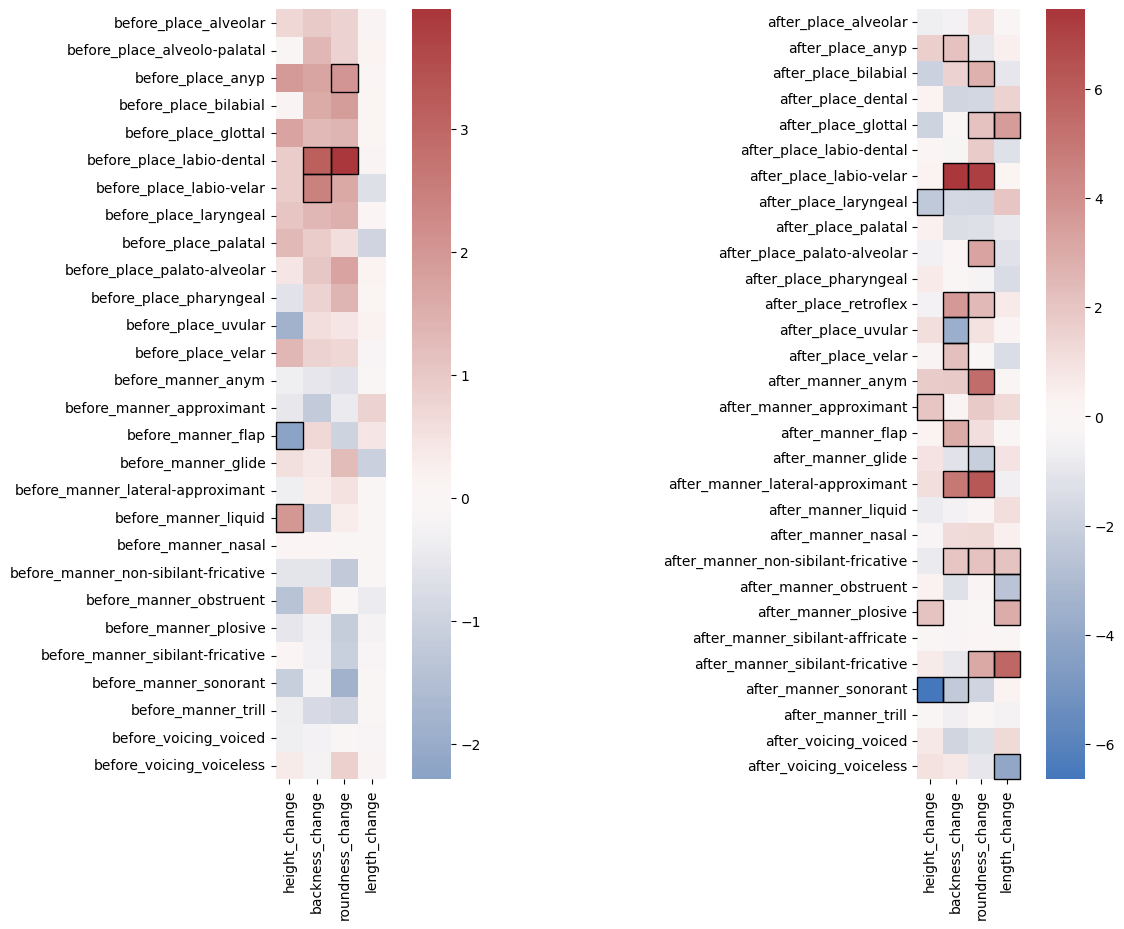

In [ ]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15,10))

sns.heatmap(before_ts[['height_change', 'backness_change', 'roundness_change', 'length_change']], center=0, cmap='vlag', square=True, ax=ax[0])
for col_i, col in enumerate(before_ts[[col for col in before_ts if col.endswith('_p')]].columns.values.tolist()):
  for row_i, row in enumerate(before_ts.index.values.tolist()):
    if before_ts[col][row] < 0.05:
      ax[0].add_patch(Rectangle((col_i, row_i), 1, 1, fill=False, edgecolor='black', lw=1, clip_on=False))
      
sns.heatmap(after_ts[['height_change', 'backness_change', 'roundness_change', 'length_change']], center=0, cmap='vlag', square=True, ax=ax[1])
for col_i, col in enumerate(after_ts[[col for col in before_ts if col.endswith('_p')]].columns.values.tolist()):
  for row_i, row in enumerate(after_ts.index.values.tolist()):
    if after_ts[col][row] < 0.05:
      ax[1].add_patch(Rectangle((col_i, row_i), 1, 1, fill=False, edgecolor='black', lw=1, clip_on=False))